# The Effect of College GPA on Success

# Overview

The goal of this project was to find the effect of college GPA on factors of career success, namely, salary and job satisfaction. We used data from the National Survey of Recent College Graduates to explore relationships between GPA and other variables across different fields of work. Using visualization and linear regression techniques, we found statistically significant correlations between college GPA and both salary and job satisfaction, and observed differences in these relationships between different college majors.

# Names

- Alessandro Todaro
- Richard Yu
- Vivek Rayalu
- Mengyu Zhang
- Hedy Wang

<a id='research_question'></a>
# Research Question

How does college GPA correlate to salary and job satisfaction for recent college graduates, and how does the correlation differ between fields/degrees?

<a id='background'></a>

## Background & Prior Work

College students like us worry about GPA a lot, but will our college GPAs significantly impact our careers? Will the extra work and stress required to get that A pay off? These questions are what prompted our research question.

We are not the first to wonder about the benefits of a good GPA. In the article "How Much Does Your College GPA Affect Your Future," the author cites data showing that many large companies (67%) screen applicants by GPA - however, this does not bar low GPA applicants completely (1). Outside of these larger employers, GPA often matters less, and the author also states that the importance of GPA decreases as you obtain more job experience through your career. The article does include results from some studies comparing GPA to salary, and they show that salary does increase with higher GPAs; at the same time, there were still significant numbers of people with high salaries and lower GPAs.

The research paper "Capturing a College Education's Impact on Industry Wages Across Time" explores the relationship between GPA and salary more deeply, by including factors such as industry (2). The author concludes that GPA does have an effect on wage, along with choice of major and field of work.

Our research here, while similar to the discussed examples, involves analysis of different and potentially more comprehensive data sets, and evaluates the relationship of new variables, such as job satisfaction and overlap between major and field of work, to hopefully provide more ways of assessing the importance of GPA.

References):
- 1) https://getblogo.com/how-much-does-your-college-gpa-affect-your-future/
- 2) https://dukespace.lib.duke.edu/dspace/bitstream/handle/10161/5129/Low_FINAL_THESIS%2004-16.pdf?isAllowed=y&sequence=1 

# Hypothesis


We expect to see a positive correlation between college GPA and salary, as well as between GPA and job satisfaction. We think this because our data consists of recent college graduates, who will mostly have little industry experience; thus, GPA might play a more significant role in their collective hiring process, making it easier for those with higher GPAs to secure well-paying jobs. This ties into job satisfaction as well, since someone with more leverage (a better GPA) would be more likely to have access to positions they might enjoy.

# Dataset

- Dataset Name: IPUMS Higher Ed
- Link to the dataset: https://highered.ipums.org/highered/index.shtml
- Number of observations: ~276,000

This dataset contains data from the National Surveys of College Graduates and Recent College Graduates, or NSCG and NSRCG respectively. Specifically, we extracted data from 1993 to 1999 pertaining to undergraduate GPA, college major, salary, and job satisfaction. 

# Setup

In [45]:
import pandas as pd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)

import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data.csv')

# Data Cleaning

Columns are renamed for easier manipulation. Rows with values that represent missing or non-applicable data are removed - the IPUMS database uses certain values, like 9999998 or 99, to represent such entries already, so removing them is easy. Empty data is NOT removed because the survey's questions changed when taken in different years, so some years do not have certain variables, but those years could still be used for analysis. Additionally, the numeric codes used by IPUMS are replaced with the descriptors they represent, for ease of use.

While the dataset we obtained contains survey results from both the NSCG and NSRCG, only the latter contains GPA data, which is critical to answering our research question. Thus, any NSCG survey responses are dropped.

In [6]:
# give columns friendlier names
df = df.rename(columns={'PERSONID':'id', 'YEAR':'year', 'SURID':'survey', 'NBAMEMG':'major', 'UGGPA':'gpa', 
                   'EXPFT':'yearsexperience', 'OCEDRLP':'jobrelated', 'SALARY':'salary', 'JOBSATIS':'jobsatisfaction'})

# salary values of 9999998 or 9999999 represent missing or error data
# GPA value of 8 represents respondent did not recall GPA or did not have one
# job related value of 98 represents missing or error data
# major value of 96 represents blank response
# job satisfaction value of 98 represents missing or error data
df = df[df['salary'] < 9999998]
df = df[df['gpa'] != 8]
df = df[df['jobrelated'] != 98]
df = df[df['major'] != 96]
df = df[df['jobsatisfaction'] != 98]


# replace numeric values with the category/descriptor they represent
df['survey'].replace([1,3],['NSCG','NSRCG'],inplace=True)
df['major'].replace([1,2,3,4,5,6,7,9],['Computer and mathematical sciences',
                                       'Life and related sciences',
                                       'Physical and related sciences',
                                       'Social and related sciences',
                                       'Engineering',
                                       'Science and engineering-related fields',
                                       'Non-science and engineering fields',
                                       'Others'],inplace=True)
df['gpa'].replace([1,2,3,4,5],['4.00 - 3.75',
                               '3.74 - 3.25',
                               '3.24 - 2.75',
                               '2.74 - 2.25',
                               '< 2.25'],inplace=True)
df['jobrelated'].replace([1,2,3],['Closely related',
                                  'Somewhat related', 
                                  'Not related',],inplace=True)
df['jobsatisfaction'].replace([1,2,3,4],['Very satisfied',
                                          'Somewhat satisfied',
                                          'Somewhat dissatisfied',
                                          'Very dissatisfied'],inplace=True)

# NSCG does not contain the data we need
df = df[df['survey'] == 'NSRCG']

# Data Analysis & Results

### Exploring Data

The data we are using comes from the National Survey of Recent College Graduates, which was conducted by the National Science Foundation. In particular, we are using the survey data from 1993, 1995, 1997, and 1999, since those years' surveys included a question about undergraduate GPA, which we need for our analysis. As seen by the shape of the dataframe, there are around 45 thousand observations from these four years - each observation being one individual's responses to the survey in a given year.

In [7]:
df.shape

(45002, 9)

Due to the nature of the survey, many of the variables are discrete: GPA, job satisfaction, and the relation between college major and field of work were given as multiple choice questions, so there are just a handful of groupings for these variables. Years of work experience and annual salary are continuous variables, however, measured in years and dollars respectively. 

In [8]:
df.head()

,id,year,survey,major,gpa,yearsexperience,jobrelated,salary,jobsatisfaction
67855,30000000000000001,1993,NSRCG,Engineering,3.24 - 2.75,3.0,Somewhat related,40000,NaN
67856,30000000000000002,1993,NSRCG,Engineering,4.00 - 3.75,2.0,Closely related,26000,NaN
67857,30000000000000003,1993,NSRCG,Engineering,3.24 - 2.75,3.0,Somewhat related,45000,NaN
67859,30000000000000005,1993,NSRCG,Non-science and engineering fields,3.74 - 3.25,1.0,Not related,13000,NaN
67860,30000000000000006,1993,NSRCG,Social and related sciences,3.24 - 2.75,2.0,Not related,21000,NaN


Additionally, the questions that were asked differed slightly in different years. For instance, job satisfaction was only surveyed once out of the four years - in 1997 only - so that variable has far fewer observations. Thus, it would be wrong to ignore rows missing this variable, since it does not indicate faulty data, and most of our analysis does not involve job satisfaction; at the same time, some analysis can be done on job satisfaction despite its smaller sample size, so it is left in the data. Similarly, data on job experience only exists for the 1993 and 1995 surveys.

As seen below, these two variables have some missing values, just as expected. Aside from these, the dataset seems to have no missing data. Considering our dataset comes from IPUMS, which does some of its own cleaning and formatting, this is not unexpected.

In [9]:
df.isna().sum()

id                     0
year                   0
survey                 0
major                  0
gpa                    0
yearsexperience    17734
jobrelated             0
salary                 0
jobsatisfaction    35886
dtype: int64

Each of the four years of the NSRCG survey received at least 8,000 responses, with responses peaking in 1995 at almost 14,000.

In [11]:
df['year'].value_counts()

1995    13961
1993    13307
1997     9116
1999     8618
Name: year, dtype: int64

By far the most common major category among survey respondents is engineering, followed by social sciences. The least common major group was non-science/engineering majors, making up roughly 2,000 respondents. This does not make analysis for those majors impossible, but the small sample size means it may be less meaningful.

In [12]:
df['major'].value_counts()

Engineering                           15862
Social and related sciences           11746
Physical and related sciences          5663
Life and related sciences              5095
Computer and mathematical sciences     4501
Non-science and engineering fields     2135
Name: major, dtype: int64

The large majority of respondents reported having a GPA somewhere near 3.25. Very few survey-takers said they had a GPA of less than 2.25.

In [13]:
df['gpa'].value_counts()

3.24 - 2.75    18080
3.74 - 3.25    14961
4.00 - 3.75     5935
2.74 - 2.25     5348
< 2.25           678
Name: gpa, dtype: int64

Most respondents had a job closely related to their major, but almost a fifth of them had one that was not related to their major at all.

In [14]:
df['jobrelated'].value_counts()

Closely related     23165
Somewhat related    13292
Not related          8545
Name: jobrelated, dtype: int64

The majority of survey-takers feel at least somewhat satisfied with their job. However, it should be noted that this data was only collected in the 1997 survey, so the scope is more limited.

In [15]:
df['jobsatisfaction'].value_counts()

Somewhat satisfied       3828
Very satisfied           3801
Somewhat dissatisfied     998
Very dissatisfied         489
Name: jobsatisfaction, dtype: int64

Salaries reported in the survey appear relatively normal, with some outliers towards the higher end of the scale. There are a handful of respondents reporting very small salaries of less than 10,000 - these respondents might be working part-time, not working at all (salary of 0), or misunderstood the question and entered their monthly salary as opposed to annual salary. In all of these cases, it is best to remove the observation for the purpose of our analysis.

In [16]:
df['salary'].describe()

count     45002.000000
mean      30435.269544
std       15279.033195
min           0.000000
25%       19000.000000
50%       30000.000000
75%       40000.000000
max      100000.000000
Name: salary, dtype: float64

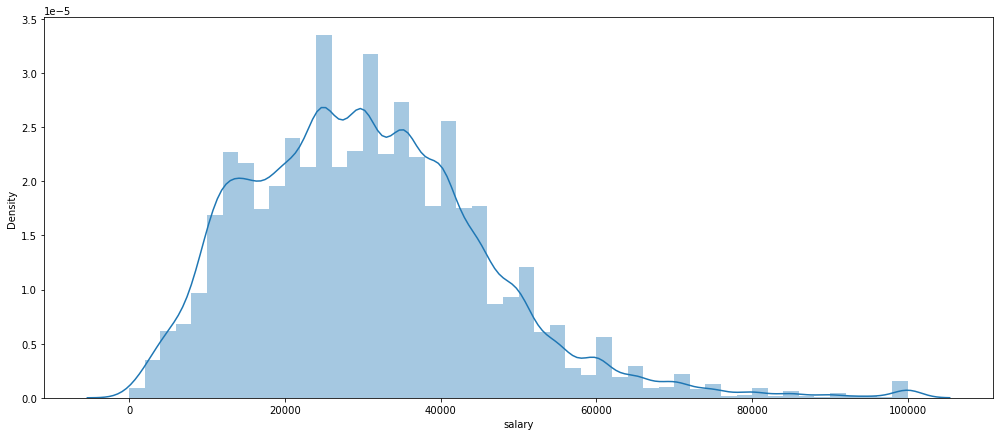

(2443, 9)

In [20]:
sns.distplot(df['salary'])
plt.show()

df[df['salary'] < 10000].shape

In [21]:
# remove salaries that are illogically low
df = df[df['salary'] > 10000]

### Analysis

We can begin with some boxplots of salary between the four GPA categories.

As seen below, the median salary seems to increase slightly with higher GPAs, with the third quartile increasing more significantly - The exception for both of these being the lowest GPA category. However, each GPA group has a significant tail, and they all reach roughly the same salary.

In [22]:
# define order
gpaorder = ['4.00 - 3.75','3.74 - 3.25','3.24 - 2.75','2.74 - 2.25','< 2.25']

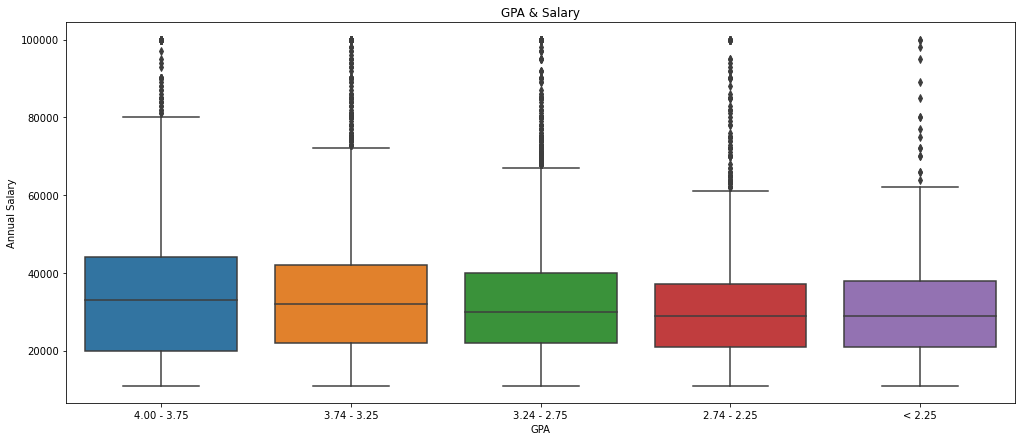

In [25]:
ax = sns.boxplot(x='gpa', y='salary', data=df, order=gpaorder)
ax.set_title('GPA & Salary')
ax.set_xlabel('GPA')
ax.set_ylabel('Annual Salary')
plt.show()

Next, we split the boxplot by whether or not the respondent's job is related to their major. The logic here is that, for jobs unrelated to major, GPA should matter less.

Interestingly, while the median salary for those with major-unrelated jobs is lower for each GPA category, both the median and third quartile salary still increase with GPA, again with the exception of the lowest group.

In [33]:
# Make column for true if job is closely/somewhat related, false otherwise
df['jobrelatedbool'] = df['jobrelated'].isin(['Closely related', 'Somewhat related'])
boolorder = [True, False]

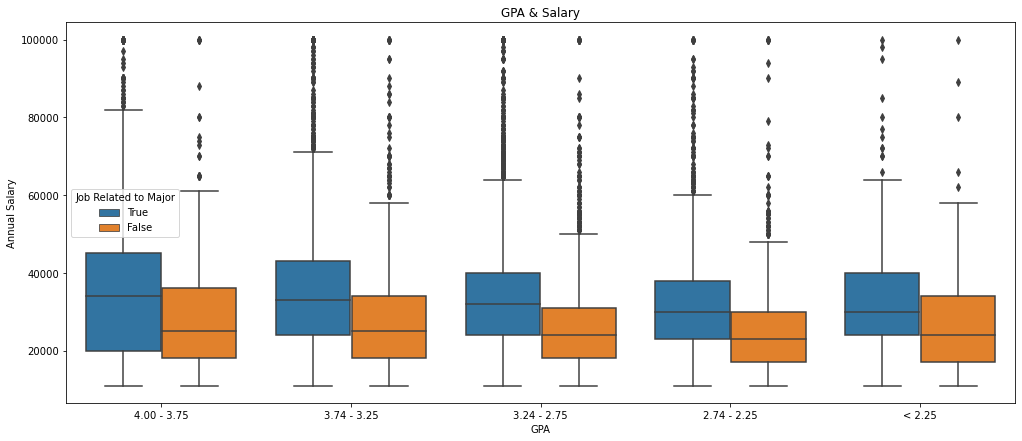

In [46]:
ax = sns.boxplot(x='gpa', y='salary', hue='jobrelatedbool', hue_order=boolorder, data=df, order=gpaorder)
ax.set_title('GPA & Salary')
ax.set_xlabel('GPA')
ax.set_ylabel('Annual Salary')
ax.axes.get_legend().set_title('Job Related to Major')

plt.show()

Now, we will create a linear model of GPA and salary and test its statistical significance, using Ordinary Least Squares, or OLS. First, we separate just the data for respondents whose jobs are related to their majors, since this is where we expect to have a more significant relationship. Then, we create the OLS model using patsy and statsmodels, and display the results. We will use an alpha of 0.05 in analysis.

The OLS model uses the GPA group of 2.74 - 2.25 as the reference variable, denoted by the fact that it does not appear as a row in the list of parameters. According to the summary, the GPA categories of 4.0 - 3.75, 3.74 - 3.25, and 3.24 - 2.75 are statistically significant predictors on salary; as the GPAs increase, so do the coefficients, which means that the expected salary for that category is higher.  
The category for the lowest GPAs, <2.25, is not a statistically significant predictor. This is most likely due to the sample size being too small.

It should be noted that the OLS model generated has an extremely low R-squared value of 0.002. R-squared is a measure of variance compared to the model - a low value means more variance. In this case, our R-squared value make sense: the range of salaries in each group is very large, and they all mostly overlap. This does not mean that the model is meaningless, however. The statistically significant coefficients represent changes in the mean salary, so those with a GPA between 4.0 and 3.75, for instance, would make roughly \$2300 more on average than someone with a GPA between 2.74 and 2.25.

In [59]:
df_related = df[df['jobrelatedbool'] == True]
df_unrelated = df[df['jobrelatedbool'] == False]

In [38]:
outcome, predictors = patsy.dmatrices('salary ~ gpa', df_related)
model = sm.OLS(outcome, predictors)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     20.78
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           4.01e-17
Time:                        21:18:28   Log-Likelihood:            -3.7548e+05
No. Observations:               34185   AIC:                         7.510e+05
Df Residuals:                   34180   BIC:                         7.510e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            3.21e+04    230.557    139.218      0.000    3.16e+04    3.25e+04
gpa[T.3.24 - 2.75]  1159.3792    261.135      4.440      0.000     647.546    1671.213
gpa[T.3.74 - 3.25]  1986.3705    265.874      7.471      0.000    1465.248    2507.493
gpa[T.4.00 - 3.75]  2354.5463    309.146      7.616      0.000    1748.610    2960.483
gpa[T.< 2.25]        457.2302    695.407      0.657      0.511    -905.791    1820.252
==============================================================================
Omnibus:                     5139.437   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10013.230
Skew:                           0.938   Prob(JB):                         0.00
Kurtosis:                       4.874   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can repeat this process on the set of data from respondents whose jobs are not related to their major, as seen below. This model is similar in many ways to the previous one, including the low R-squared. Here, perhaps surprisingly, there are some GPA groups that are statistically significant predictors: 4.0 - 3.75 and 3.74 - 3.25. In fact, the coefficients for these groups are higher than they were in the previous model, signifying they make a larger difference in mean salary.

In [60]:
outcome_ur, predictors_ur = patsy.dmatrices('salary ~ gpa', df_unrelated)
model_ur = sm.OLS(outcome_ur, predictors_ur)
result_ur = model_ur.fit()

result_ur.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     12.24
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           6.41e-10
Time:                        22:04:13   Log-Likelihood:                -80518.
No. Observations:                7399   AIC:                         1.610e+05
Df Residuals:                    7394   BIC:                         1.611e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.552e+04    372.210     68.550      0.000    2.48e+04    2.62e+04
gpa[T.3.24 - 2.75]   621.6228    433.533      1.434      0.152    -228.226    1471.471
gpa[T.3.74 - 3.25]  2040.7433    466.894      4.371      0.000    1125.498    2955.989
gpa[T.4.00 - 3.75]  3716.6615    649.065      5.726      0.000    2444.310    4989.013
gpa[T.< 2.25]       1906.6617   1066.942      1.787      0.074    -184.849    3998.173
==============================================================================
Omnibus:                     2924.394   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14794.033
Skew:                           1.855   Prob(JB):                         0.00
Kurtosis:                       8.850   Cond. No.                         8.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analysis by Major

The next step is to compare the effect of GPA in different majors. First, we split the dataframe by major, and graph their boxplots. For the sake of visual clarity, only the data from respondents whose jobs relate to their major is visualized.

The boxplots below show some interesting differences across categories of majors. For some, like engineering or computer and math related majors, salaries seem to trend significantly upward with GPA. For others, like life sciences, there are fewer differences. Strangely, the physical science-related majors with the highest GPAs have the lowest median salary of any group.

In [56]:
# group by major
engineering = df_related[df_related['major'] == 'Engineering']
lifesciences = df_related[df_related['major'] == 'Life and related sciences']
nonscience = df_related[df_related['major'] == 'Non-science and engineering fields']
compmathsciences = df_related[df_related['major'] == 'Computer and mathematical sciences']
socialsciences = df_related[df_related['major'] == 'Social and related sciences']
physicalsciences = df_related[df_related['major'] == 'Physical and related sciences']

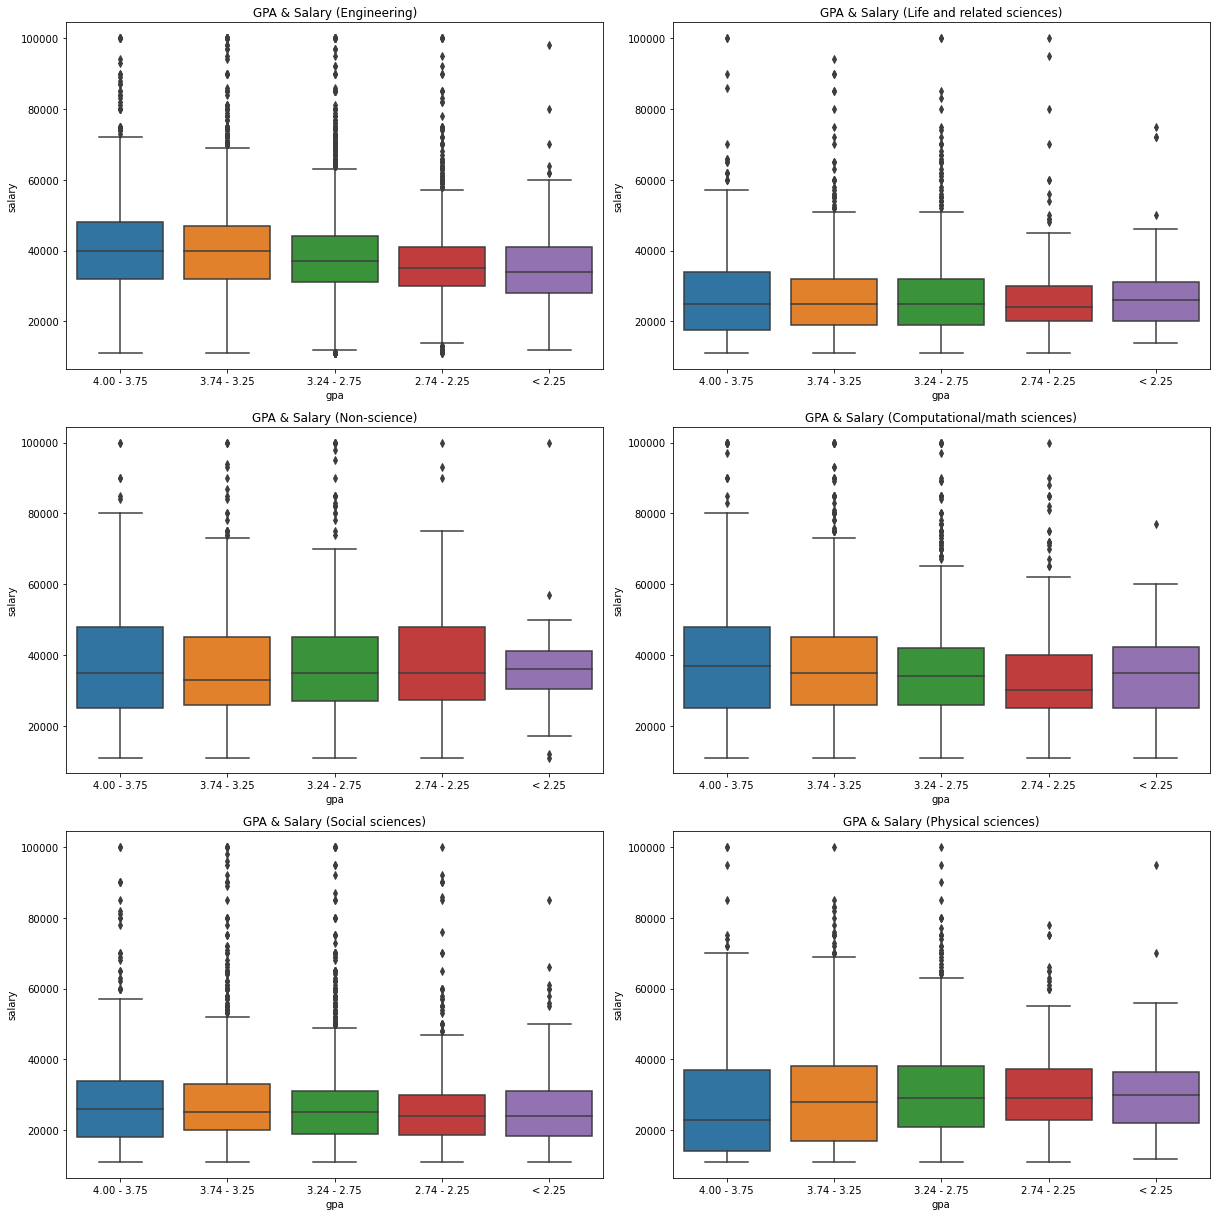

In [57]:
# plt.rcParams['figure.figsize'] = (17, 17)

plt.subplots(3, 2, figsize=(17,17))

plt.subplot(3, 2, 1)
sns.boxplot(x='gpa', y='salary', data=engineering, order=gpaorder).set_title('GPA & Salary (Engineering)')

plt.subplot(3, 2, 2)
sns.boxplot(x='gpa', y='salary', data=lifesciences, order=gpaorder).set_title('GPA & Salary (Life and related sciences)')

plt.subplot(3, 2, 3)
sns.boxplot(x='gpa', y='salary', data=nonscience, order=gpaorder).set_title('GPA & Salary (Non-science)')

plt.subplot(3, 2, 4)
sns.boxplot(x='gpa', y='salary', data=compmathsciences, order=gpaorder).set_title('GPA & Salary (Computational/math sciences)')

plt.subplot(3, 2, 5)
sns.boxplot(x='gpa', y='salary', data=socialsciences, order=gpaorder).set_title('GPA & Salary (Social sciences)')

plt.subplot(3, 2, 6)
sns.boxplot(x='gpa', y='salary', data=physicalsciences, order=gpaorder).set_title('GPA & Salary (Physical sciences)')

plt.tight_layout()
plt.show()

We will again build linear models to test the significance of GPA against salary, this time only using data from one set of majors. 

In [58]:
outcome_e, predictors_e = patsy.dmatrices('salary ~ gpa', engineering)
model_e = sm.OLS(outcome_e, predictors_e)
result_e = model_e.fit()

result_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     25.50
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           4.46e-21
Time:                        22:00:26   Log-Likelihood:            -1.5101e+05
No. Observations:               13853   AIC:                         3.020e+05
Df Residuals:                   13848   BIC:                         3.021e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.631e+04    322.394    112.632      0.000    3.57e+04    3.69e+04
gpa[T.3.24 - 2.75]  1811.1617    367.196      4.932      0.000    1091.409    2530.915
gpa[T.3.74 - 3.25]  3185.8984    375.979      8.474      0.000    2448.928    3922.868
gpa[T.4.00 - 3.75]  3367.1028    445.557      7.557      0.000    2493.752    4240.454
gpa[T.< 2.25]       -838.1373   1005.453     -0.834      0.405   -2808.960    1132.686
==============================================================================
Omnibus:                     1423.583   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3513.850
Skew:                           0.606   Prob(JB):                         0.00
Kurtosis:                       5.149   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above model, looking at engineering majors, is very similar to the one created from looking at all of the data. The GPA ranges 4.0 - 3.75, 3.74 - 3.25, and 3.24 - 2.75 are all statistically significant predictors, while GPAs of <2.25 are not. Additionally, we have a very low R-squared value again.

Interestingly, the coefficients for the different GPA groups are higher than the corresponding coefficients from the model for all majors, meaning higher GPAs correlate to greater salary increases comparatively. Given the complexity of the engineering field, this seems logical.

In [61]:
outcome_l, predictors_l = patsy.dmatrices('salary ~ gpa', lifesciences)
model_l = sm.OLS(outcome_l, predictors_l)
result_l = model_l.fit()

result_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.756
Date:                Sun, 14 Mar 2021   Prob (F-statistic):              0.135
Time:                        22:12:07   Log-Likelihood:                -38101.
No. Observations:                3541   AIC:                         7.621e+04
Df Residuals:                    3536   BIC:                         7.624e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.569e+04    568.064     45.232      0.000    2.46e+04    2.68e+04
gpa[T.3.24 - 2.75]   910.6402    636.236      1.431      0.152    -336.787    2158.067
gpa[T.3.74 - 3.25]   951.0070    662.584      1.435      0.151    -348.078    2250.092
gpa[T.4.00 - 3.75]  1863.9577    813.783      2.290      0.022     268.425    3459.490
gpa[T.< 2.25]       3022.1921   1666.255      1.814      0.070    -244.726    6289.110
==============================================================================
Omnibus:                     1308.904   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6583.504
Skew:                           1.704   Prob(JB):                         0.00
Kurtosis:                       8.745   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model, analyzing life sciences majors, produces no statistically significant predictors from GPA. This matches the graphical analysis of the boxplots: between different GPAs, there are few significant differences in salary.

In [62]:
outcome_n, predictors_n = patsy.dmatrices('salary ~ gpa', nonscience)
model_n = sm.OLS(outcome_n, predictors_n)
result_n = model_n.fit()

result_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6846
Date:                Sun, 14 Mar 2021   Prob (F-statistic):              0.603
Time:                        22:14:46   Log-Likelihood:                -19753.
No. Observations:                1779   AIC:                         3.952e+04
Df Residuals:                    1774   BIC:                         3.954e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.823e+04   1331.578     28.707      0.000    3.56e+04    4.08e+04
gpa[T.3.24 - 2.75]  -360.8589   1479.401     -0.244      0.807   -3262.410    2540.693
gpa[T.3.74 - 3.25] -1682.1137   1473.764     -1.141      0.254   -4572.609    1208.382
gpa[T.4.00 - 3.75]  -705.3173   1593.423     -0.443      0.658   -3830.500    2419.866
gpa[T.< 2.25]       -965.1578   3609.492     -0.267      0.789   -8044.462    6114.146
==============================================================================
Omnibus:                      307.643   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              553.028
Skew:                           1.076   Prob(JB):                    8.16e-121
Kurtosis:                       4.681   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Just like the life sciences model, this non-science model does not show any statistical signifigance in GPA.

In [63]:
outcome_c, predictors_c = patsy.dmatrices('salary ~ gpa', compmathsciences)
model_c = sm.OLS(outcome_c, predictors_c)
result_c = model_c.fit()

result_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.179
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           5.94e-05
Time:                        22:16:32   Log-Likelihood:                -41625.
No. Observations:                3759   AIC:                         8.326e+04
Df Residuals:                    3754   BIC:                         8.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.408e+04    856.381     39.793      0.000    3.24e+04    3.58e+04
gpa[T.3.24 - 2.75]  1409.9047    955.346      1.476      0.140    -463.143    3282.952
gpa[T.3.74 - 3.25]  2874.2112    957.536      3.002      0.003     996.871    4751.552
gpa[T.4.00 - 3.75]  4250.7097   1040.781      4.084      0.000    2210.159    6291.260
gpa[T.< 2.25]        812.9911   2454.902      0.331      0.741   -4000.081    5626.063
==============================================================================
Omnibus:                      627.481   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1194.239
Skew:                           1.028   Prob(JB):                    4.72e-260
Kurtosis:                       4.843   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Like engineering, there are some statistically significant GPA groups here: 4.0 - 3.75 and 3.74 - 3.25. In fact, the coefficient for the highest GPA group is higher than that of any significant GPA category thus far. Computer science and mathematics are known for their academic rigor, so the impact of GPA here makes sense.

In [65]:
outcome_s, predictors_s = patsy.dmatrices('salary ~ gpa', socialsciences)
model_s = sm.OLS(outcome_s, predictors_s)
result_s = model_s.fit()

result_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.333
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           4.40e-05
Time:                        22:22:25   Log-Likelihood:                -74695.
No. Observations:                6913   AIC:                         1.494e+05
Df Residuals:                    6908   BIC:                         1.494e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.574e+04    408.769     62.973      0.000    2.49e+04    2.65e+04
gpa[T.3.24 - 2.75]   992.9171    467.640      2.123      0.034      76.199    1909.636
gpa[T.3.74 - 3.25]  2016.1211    477.483      4.222      0.000    1080.108    2952.134
gpa[T.4.00 - 3.75]  2223.1716    573.787      3.875      0.000    1098.373    3347.970
gpa[T.< 2.25]       1439.3705   1296.076      1.111      0.267   -1101.336    3980.077
==============================================================================
Omnibus:                     2919.272   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17200.759
Skew:                           1.942   Prob(JB):                         0.00
Kurtosis:                       9.681   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model, for social sciences, shows some statistically significant GPA categories as well. However, the coefficients of the two groups (4.0 - 3.75 and 3.74 - 3.25) are lower than for engineering or computer & math majors, signifying a smaller impact.

In [66]:
outcome_p, predictors_p = patsy.dmatrices('salary ~ gpa', physicalsciences)
model_p = sm.OLS(outcome_p, predictors_p)
result_p = model_p.fit()

result_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.383
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           9.85e-07
Time:                        22:25:12   Log-Likelihood:                -47466.
No. Observations:                4340   AIC:                         9.494e+04
Df Residuals:                    4335   BIC:                         9.497e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.083e+04    654.841     47.075      0.000    2.95e+04    3.21e+04
gpa[T.3.24 - 2.75]  -374.7160    737.288     -0.508      0.611   -1820.177    1070.745
gpa[T.3.74 - 3.25] -1402.9655    740.287     -1.895      0.058   -2854.307      48.376
gpa[T.4.00 - 3.75] -3685.4393    838.849     -4.393      0.000   -5330.012   -2040.867
gpa[T.< 2.25]        794.8232   1798.783      0.442      0.659   -2731.711    4321.357
==============================================================================
Omnibus:                      637.434   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1070.533
Skew:                           0.977   Prob(JB):                    3.44e-233
Kurtosis:                       4.450   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our final model, for physical sciences, shows only one statistically significant GPA category, the highest one. And, just as observed from the boxplots, its effect on salary is actually negative. This is strange, but could be explained by the small sample size, or perhaps a tendency among those with higher GPAs to pursue careers in academia, which might provide lower starting salaries.

### Job Satisfaction

Since our dataset includes respondents' job satisfaction rating, we will analyze it as well. Below is a bar plot counting the respondents who answered the varying levels of job satisfaction, grouped by their GPA. For a more easily understood visualization, the number of responses was normalized within each GPA group to show the percentage of respondents who answered in each satisfaction category.

From just looking at the plot, there seems to be a slight shift towards lower satisfaction as GPA decreases. We can test this further.

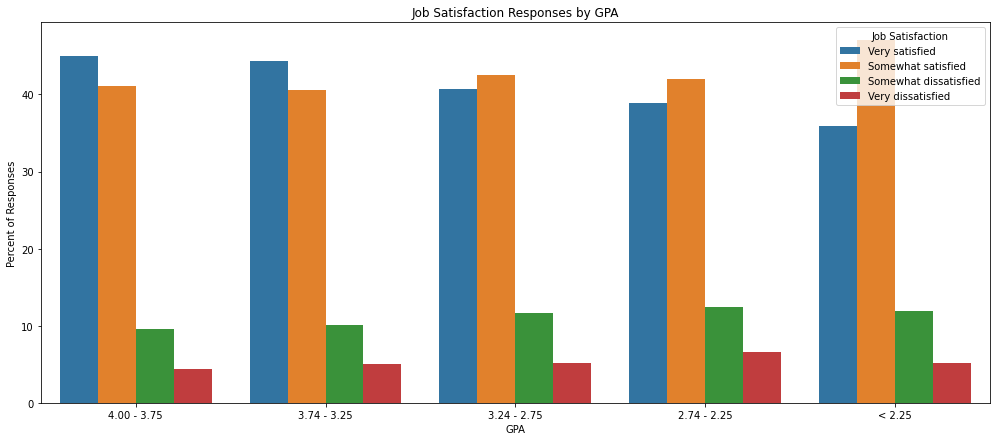

In [76]:
satisfactionorder = ['Very satisfied', 'Somewhat satisfied', 'Somewhat dissatisfied', 'Very dissatisfied']

pcts_df = df.groupby('gpa')['jobsatisfaction'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

ax = sns.barplot(x='gpa', y='percent', hue='jobsatisfaction', order=gpaorder, hue_order=satisfactionorder, data=pcts_df)

ax.set_title('Job Satisfaction Responses by GPA')
ax.set_xlabel('GPA')
ax.set_ylabel('Percent of Responses')
ax.axes.get_legend().set_title('Job Satisfaction')

plt.show()

In [78]:
df['numericsatisfaction'] = df['jobsatisfaction'].replace(['Very satisfied',
                                          'Somewhat satisfied',
                                          'Somewhat dissatisfied',
                                          'Very dissatisfied'],[4,3,2,1])

outcome_satis, predictors_satis = patsy.dmatrices('numericsatisfaction ~ gpa', df)
model_satis = sm.OLS(outcome_satis, predictors_satis)
result_satis = model_satis.fit()

result_satis.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     numericsatisfaction   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     4.977
Date:                 Sun, 14 Mar 2021   Prob (F-statistic):           0.000525
Time:                         22:56:45   Log-Likelihood:                -10174.
No. Observations:                 8235   AIC:                         2.036e+04
Df Residuals:                     8230   BIC:                         2.039e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.1335      0.028    113.782      0.000       3.079       3.187
gpa[T.3.24 - 2.75]     0.0534      0.031      1.717      0.086      -0.008       0.114
gpa[T.3.74 - 3.25]     0.1083      0.032      3.416      0.001       0.046       0.170
gpa[T.4.00 - 3.75]     0.1318      0.038      3.496      0.000       0.058       0.206
gpa[T.< 2.25]          0.0033      0.082      0.040      0.968      -0.157       0.164
==============================================================================
Omnibus:                      925.999   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1264.450
Skew:                          -0.941   Prob(JB):                    2.68e-275
Kurtosis:                       3.383   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above OLS model compares GPA to job satisfaction, converting the satisfaction ratings into numeric values for easier use. According to the summary, the two highest GPA groups are statistically significant predictors, with coefficients of roughly .11 and .13. Given that the numeric values for satisfaction were the integers from 1 through 4, these coefficients represent a small but not insignificant trend.

# Ethics & Privacy

The dataset we obtained from IPUMS is anonymized to remove any information that could be used to identify anyone taking the survey. The only unique identifier available is the ID number assigned by IPUMS, which can only be used to cross-reference other datasets. The National Survey of Recent College Graduates (NSRCG) is funded by the National Science Foundation, and conducted by the United States Census Bureau. Taking the survey is voluntary, as is answering any particular question within, and the Census Bureau is required by law to keep responses confidential and provide them only for the purposes of statistical analysis, such as for this research project. This information is made available to anyone initially chosen for the NSRCG.

Surveys are distributed in such a way to create representative samples of the population of college graduates in the United States. Thus, biases in the dataset itself in regards to race, gender, geographic location, etc. should be low. The particular dataset we extracted for use in our analysis does not contain any such personal data, however, so any existing biases could not have been corrected by us.

Despite revealing a positive correlation between GPA and salary, we believe that this may be because students with higher GPAs may have more resources and be less burdened by environmental factors (like maybe students that need a part time job have lower GPAs to balance school and work). Thus, this positive correlation between GPA and salary may reflect an institutional inequality in resources, rather than a difference in earning potential among students.

# Conclusion & Discussion

Our analysis of the data using linear regress confirmed our hypothesis that salary and job satisfaction would increase with GPA. Looking at all majors together, GPA had a small but significant effect on salary. In analyzing each major individually, certain majors had greater salary differences between GPAs than others. Some majors produced regression models with no statistically significant variables, signifying that either the effect of GPA on salary was negligible, or the data was not comprehensive enough. In our regression analysis of job satisfaction, we found that those with higher GPAs were slightly more satisfied with their jobs, on average.

In all of the analyses described above, our models showed very low R-squared values, meaning that the coefficients pertained mostly to the means of the data due to the high variation. This can be seen in the visualizations of the data: plots of salary between different GPAs mostly overlap with each other. This represents that, although someone with a higher GPA may be more likely to have a higher salary, GPA is far from the be-all and end-all in regards to future wages. There are a multitude of factors affecting salary that were not analyzed here, and GPA may be a confounding variable of some of them, such as individual motivation. Our analysis had other limitations as well. The dataset used only contains responses from 1993 to 1999 - the job market has changed dramatically in the last 25 years, espeically in fields such as computer science, so relationships might be different in more recent data. Additionally, the GPA data within the dataset was organized categorically, into ranges of GPA values, instead of individual scores. A dataset with more granular GPA data would be easier to model, and might provide more meaningful relationships between GPA and salary.

The implications of this research on society are not particularly large, since similar research has already been published. Some students may become inspired to study harder and worry more about their grades, but any societal impact beyond that seems unlikely.

# Team Contributions

**Alessandro Todaro, Vivek Rayalu:** Data cleaning, data visualization, data analysis, writing  
**Richard Yu:** Organization, video voiceover, writing    
**Mengyu Zhang:** Data visualization, writing  
**Hedy Wang:** Video visuals, writing